In [312]:
%load_ext autoreload
%autoreload 2

import os
import sys
import pickle
sys.path.append('../')
from src.DataLoader import DataLoader
import pandas as pd

from src.DataLoader import DataLoader
from src.windows_statistical_features import windows_statistical_features
from src.preprocessor import preprocessing
from src.windows_FFT_features import windows_FFT_features
from src.windows_Wavelet_features import windows_Wavelet_features
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from interface.main_local import load_data
import xgboost as xgb
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, train_test_split

import seaborn as sns

import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers, optimizers, callbacks
import tensorflow as tf
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling2D, MaxPooling1D, LSTM, Dense, Dropout, Flatten, Input, BatchNormalization

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
print(sys.path)

['/home/capnjacksparrow/code/CapnJackSparrow/09-IMU-based-fatigue-detection', '/home/capnjacksparrow/code/CapnJackSparrow/04-Decision-Science/01-Project-Setup/data-context-and-setup', '/home/capnjacksparrow/code/CapnJackSparrow/09-IMU-based-fatigue-detection/notebooks', '/home/capnjacksparrow/.pyenv/versions/3.10.6/lib/python310.zip', '/home/capnjacksparrow/.pyenv/versions/3.10.6/lib/python3.10', '/home/capnjacksparrow/.pyenv/versions/3.10.6/lib/python3.10/lib-dynload', '', '/home/capnjacksparrow/.pyenv/versions/3.10.6/envs/walkies/lib/python3.10/site-packages', '../', '../', '../', '../']


In [313]:
def resampling_test_data(csv_file_path):

    """
    Reads a CSV file, checks if the time vector is equally spaced,
    deduces the sampling rate, and resamples the dataset at 32 Hz.
    Returns a DataFrame with columns 'Time [s]', 'X_acceleration',
    'Y_acceleration', and 'Z_acceleration'.

    Args:
        csv_file_path (str): Path to the input CSV file.

    Returns:
        pd.DataFrame: Resampled DataFrame with columns 'X_acceleration',
                      'Y_acceleration', 'Z_acceleration', and 'UNIX_Time'.
    """

    orig_sampling_rate = 32 # [Hz]

    try:
        # Read the CSV file and skip the first row
        df = pd.read_csv(f"{csv_file_path}/Accelerometer.csv", header=None)

        # Remove the first 2 rows
        df = df.iloc[2:]

        # Rename columns (adjust column names as needed)
        column_mapping = {
            0: 'Initial_UNIX_time',
            1: 'Seconds_elapsed',
            2: 'Z_acceleration',
            3: 'Y_acceleration',
            4: 'X_acceleration'
        }
        df.rename(columns=column_mapping, inplace=True)

        # Convert all columns to numeric
        for col in df.columns:
            df[col] = pd.to_numeric(df[col])

        # Declare a robust scaler

        scaler = RobustScaler()

        df[['X_acceleration',
            'Y_acceleration',
            'Z_acceleration']] = scaler.fit_transform(df[['X_acceleration',
                                        'Y_acceleration',
                                        'Z_acceleration']])

        # Convert the UNIX time to a float with separator after the 10th digit
        df['Initial_UNIX_time'] = df['Initial_UNIX_time'].astype(str).str[:10] + '.' \
                                + df['Initial_UNIX_time'].astype(str).str[10:13]

        # Transform the UNIX time into date and time
        df['Initial_UNIX_time'] = pd.to_datetime(df['Initial_UNIX_time'], unit='s')

        # Set the UNIX time as dataframe index
        df.set_index('Initial_UNIX_time', inplace=True)

        # Resample the dataframe to 32 Hz
        df = df.resample('31.25ms').nearest()

        # Convert DatetimeIndex to UNIX timestamps in milliseconds
        df['UNIX_time'] = (df.index - pd.Timestamp('1970-01-01')) // pd.Timedelta('1ms')

        # Reset the index
        df.reset_index(inplace = True)

        # Calculate the total length of the DataFrame
        total_duration = len(df)
        # Calculate the start time for the 30-minute window (center of data)
        window_start = (total_duration - 57600) // 2
        # Calculate the end time for the 30-minute window (center of data)
        window_end = window_start + 57600
        # Extract data within a 30-minute window located at the center of
        # original DataFrame
        df = df.iloc[window_start:window_end]

        return df[['X_acceleration', 'Y_acceleration', 'Z_acceleration', 'UNIX_time']]

    except FileNotFoundError:
        print(f"Error: CSV file '{csv_file_path}/Accelerometer.csv' not found.")
        return None

In [327]:
path_data = os.path.join('..', 'data', 'test', 'Traian_walk_fresh')
test_data = resampling_test_data(path_data)
test_data.head()

/tmp/ipykernel_339371/1288874479.py:21: DtypeWarning: Columns (0,1,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"{csv_file_path}/Accelerometer.csv", header=None)
/tmp/ipykernel_339371/1288874479.py:55: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['Initial_UNIX_time'] = pd.to_datetime(df['Initial_UNIX_time'], unit='s')


,X_acceleration,Y_acceleration,Z_acceleration,UNIX_time
9349,-0.605178,-0.466439,0.487905,1716687447781
9350,-0.270028,-0.200730,0.544974,1716687447812
9351,-1.043351,0.097694,1.199847,1716687447843
9352,-1.738727,0.772908,1.244304,1716687447875
9353,-0.807268,1.466030,1.946451,1716687447906


In [328]:
def split_and_filter_dataframes(df):
    """
    Splits a DataFrame into smaller DataFrames of length 2880 and returns
    only those DataFrames that do not have any NaN values.

    Args:
        df (pd.DataFrame): Input DataFrame.

    Returns:
        List[pd.DataFrame]: List of filtered DataFrames.
    """
    chunk_size = 2880
    num_chunks = len(df) // chunk_size

    filtered_dataframes = []
    for i in range(num_chunks):
        start_idx = i * chunk_size
        end_idx = (i + 1) * chunk_size
        chunk_df = df.iloc[start_idx:end_idx]

        # Check if the chunk contains any NaN values
        if not chunk_df.isnull().values.any():
            filtered_dataframes.append(chunk_df)

    return filtered_dataframes

In [289]:
# load the model from disk

filename = "voting_clf_model.pkl"
loaded_model = pickle.load(open(filename, 'rb'))

/home/capnjacksparrow/.pyenv/versions/3.10.6/envs/walkies/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.4.2 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/capnjacksparrow/.pyenv/versions/3.10.6/envs/walkies/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.4.2 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/capnjacksparrow/.pyenv/versions/3.10.6/envs/walkies/lib/python3.10/site-packages/sklearn/base.py:3

In [329]:
alpha = split_and_filter_dataframes(test_data)


In [330]:
beta = [alpha[i][['X_acceleration', 'Y_acceleration', 'Z_acceleration']].to_numpy().flatten().reshape(1, -1) for i in range(len(alpha))]

In [331]:
charlie = [loaded_model.predict(i)[0] for i in beta]

In [333]:
charlie.count(1)

11

In [214]:
len(test_data), len(accel_S3)

(57600, 57600)

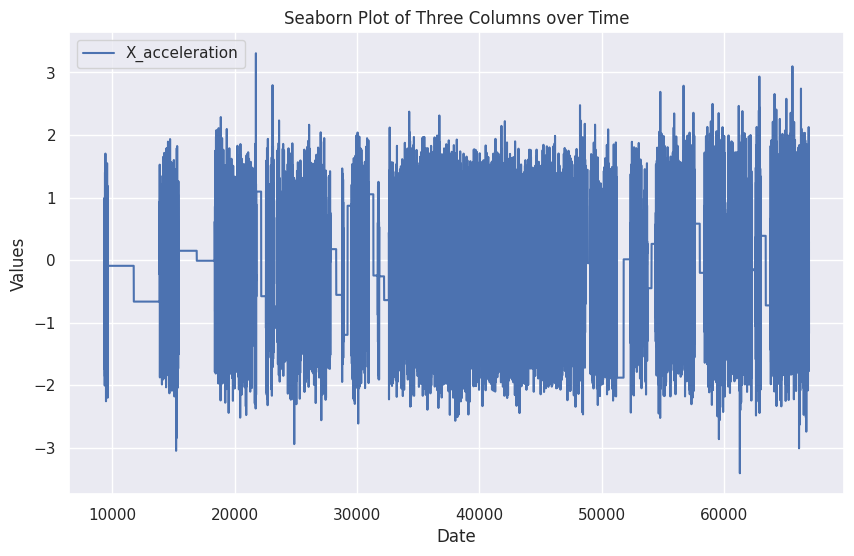

In [335]:
import matplotlib.pyplot as plt
# Set Seaborn style (optional)
sns.set(style='darkgrid')

# Create a line plot using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=test_data[['X_acceleration']], dashes=False)
plt.title('Seaborn Plot of Three Columns over Time')
plt.xlabel('Date')
plt.ylabel('Values')
plt.show()

In [89]:
os.getcwd()

'/home/capnjacksparrow/code/CapnJackSparrow/09-IMU-based-fatigue-detection/notebooks'

../data/test/Traian_walk_weary/Accelerometer.csv


/tmp/ipykernel_339371/3589999340.py:63: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['UNIX_time'] = pd.to_datetime(df['UNIX_time'], unit='s')


,X_acceleration,Y_acceleration,Z_acceleration
UNIX_time,,,
2024-05-25 04:00:40.187500,0.000000,0.000000,0.000000
2024-05-25 04:00:40.218750,0.013563,0.001175,-0.084870
2024-05-25 04:00:40.250000,0.050465,0.098027,-0.130903
2024-05-25 04:00:40.281250,-0.028127,0.034871,0.098366
2024-05-25 04:00:40.312500,0.019699,0.035599,0.162017


In [110]:
len(test_data)

77350

In [115]:
from src.DataLoader import DataLoader

accel_S3 = DataLoader().load_ACC_data("S3", "morning")

In [117]:
len(accel_S3)

57600

In [2]:
from src.DataLoader import DataLoader
import numpy as np

def retrieve_dataset():
    summary = DataLoader().data_summary()
    mapping = {"morning": "morning-mental fatigue state",
               "evening": "evening-mental fatigue state"}
    FFT_features = pd.DataFrame()
    Wavelet_features = pd.DataFrame()
    FFT_target = []
    Wavelet_target = []
    for subject in DataLoader().subjects:
        for event in DataLoader().events:
            df = DataLoader().load_ACC_data(subject,event)
            FFT_df = windows_FFT_features(df)
            Wavelet_df = windows_Wavelet_features(df)
            target_i = summary[summary["subjects"] == subject][mapping.get(event)]
            target_FFT_i = np.ones(len(FFT_df)) * int(target_i)
            target_Wavelet_i = np.ones(len(Wavelet_df)) * int(target_i)
            FFT_features = pd.concat([FFT_features, FFT_df], axis = 0)
            Wavelet_features = pd.concat([Wavelet_features, Wavelet_df], axis = 0)
            FFT_target.append(target_FFT_i)
            Wavelet_target.append(target_Wavelet_i)

    FFT_target = np.array(FFT_target).flatten()
    FFT_target = np.where(FFT_target >= 12, 1, 0).astype(int)
    Wavelet_target = np.array(Wavelet_target).flatten()
    Wavelet_target = np.where(Wavelet_target >= 12, 1, 0).astype(int)

    return FFT_features, FFT_target, Wavelet_features, Wavelet_target

FFT_features, FFT_target, Wavelet_features, Wavelet_target = retrieve_dataset()


/home/capnjacksparrow/code/CapnJackSparrow/09-IMU-based-fatigue-detection/src/windows_FFT_features.py:196: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  features_df = pd.concat([features_df, features], ignore_index=True)
/home/capnjacksparrow/code/CapnJackSparrow/09-IMU-based-fatigue-detection/src/windows_Wavelet_features.py:174: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  features_df = pd.concat([features_df, features], ignore_index=True)
/tmp/ipykernel_317751/2921849819.py:18: FutureWarning:

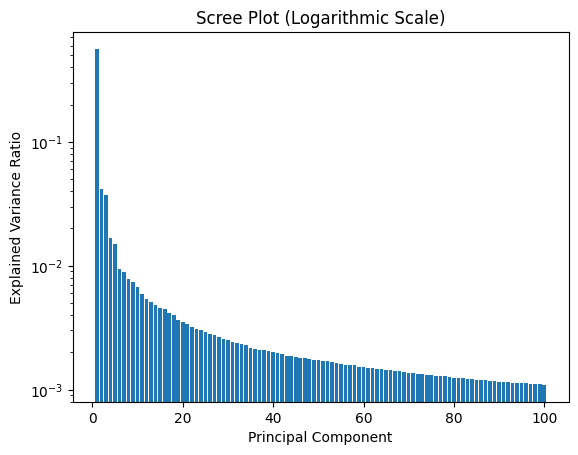

In [26]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Initialize StandardScaler
scaler = StandardScaler()

# Standardize the data
scaled_FFT_features = scaler.fit_transform(FFT_features)

pca = PCA(n_components=100)
FFT_features_pca = pca.fit_transform(scaled_FFT_features)

# Explained Variance Ratio
explained_variance = pca.explained_variance_ratio_

# Plot the Feature Explained Variance (Scree Plot) with a logarithmic y-axis
plt.bar(range(1, len(explained_variance) + 1), explained_variance)
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot (Logarithmic Scale)")
plt.yscale("log")  # Set y-axis to logarithmic scale
plt.show()

In [3]:
PCA_FFT_features = preprocessing(FFT_features)

In [4]:
PCA_FFT_features

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,14.407493,-2.327618,-3.876227,0.452312,-0.493650,-0.227840,3.125281,0.988652,1.827681,-0.281940
1,1.866136,0.719176,-2.347787,-0.622547,-0.002326,-0.151359,1.088215,-0.830544,1.368589,-0.890355
2,27.219216,-5.908895,-4.153350,-6.791456,3.518945,0.005247,4.480315,-3.177184,4.023310,-0.492655
3,9.535733,-2.036680,-0.917823,-0.380002,-0.693192,-0.217165,1.830409,-0.284933,0.715756,-2.330319
4,12.343365,-1.981034,-3.323051,2.262202,1.953890,-1.067211,1.754206,-1.208026,0.972724,-0.461399
...,...,...,...,...,...,...,...,...,...,...
16555,-6.915081,0.421398,-0.442268,-0.770568,0.970189,-0.506556,-0.135965,-0.174880,-0.481419,-0.795204
16556,-5.306173,0.540014,0.237057,-0.023327,0.087621,-0.485637,0.171335,0.054140,-0.406121,-0.680812
16557,-7.301957,-0.227244,-0.256160,-0.206074,0.353141,-0.487311,0.457947,-0.080336,-0.245469,-0.782762
16558,-8.227774,-0.397907,0.090766,0.077010,-0.050614,-0.308367,0.740507,-0.282696,-0.130384,-0.701814


In [12]:
PCA_FFT_features.shape, FFT_target.shape, FFT_features.shape, Wavelet_features.shape

((16560, 100), (16560,), (16560, 243), (16560, 255))

In [31]:
# Define XGBoost parameters
param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "n_estimators": [100, 200, 300],
    "subsample": [0.8, 0.9, 1.0],
}

# Create an XGBoost classifier
xgb_model = xgb.XGBClassifier(objective="binary:logistic")

# Perform grid search with cross-validation
kfold = KFold(n_splits=10)
grid_search = GridSearchCV(
    xgb_model, param_grid, cv=kfold, scoring="accuracy", n_jobs=-1
)
grid_search.fit(PCA_FFT_features, FFT_target)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

Best hyperparameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.9}


In [34]:
grid_search.best_score_

0.4760265700483092

In [7]:
FFT_features_exp.shape

(16560, 10, 1)

In [30]:
FFT_features_exp = np.expand_dims(PCA_FFT_features, axis=-1) if PCA_FFT_features.shape[-1] != 1 else PCA_FFT_features

X_train, X_test, y_train, y_test = train_test_split(FFT_features_exp, FFT_target, test_size=0.3)
display(X_train.shape)
display(X_test.shape)
display(y_train.shape)
display(y_test.shape)

input_shape=X_train.shape[1:]

# Define the CNN model
model = Sequential()
model.add(Input(shape=(10,1)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))  # For binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'precision', 'recall'])

# Fit the model
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.2, shuffle=True)

# Evaluate the model
test_accuracy, test_loss, test_precision, test_recall = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy}')

(11592, 10, 1)

(4968, 10, 1)

(11592,)

(4968,)

Epoch 1/25
290/290 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.5193 - loss: 0.7891 - precision: 0.5311 - recall: 0.5525 - val_accuracy: 0.5257 - val_loss: 0.6886 - val_precision: 0.5788 - val_recall: 0.3827
Epoch 2/25
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5585 - loss: 0.6914 - precision: 0.5667 - recall: 0.6016 - val_accuracy: 0.5727 - val_loss: 0.6782 - val_precision: 0.5820 - val_recall: 0.6849
Epoch 3/25
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5455 - loss: 0.6859 - precision: 0.5563 - recall: 0.6069 - val_accuracy: 0.5692 - val_loss: 0.6783 - val_precision: 0.5834 - val_recall: 0.6523
Epoch 4/25
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5884 - loss: 0.6687 - precision: 0.5968 - recall: 0.6267 - val_accuracy: 0.5683 - val_loss: 0.6751 - val_precision: 0.5640 - val_recall: 0.8143
Epoch 5/25
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5978 - loss: 0.6684 - precision: 0.5987 - recall: 0.6824 - val_accuracy: 0.5727 - val_los

In [12]:
model.evaluate(X_test, y_test)

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5961 - loss: 0.6569 - precision: 0.6046 - recall: 0.6957


[0.6535658836364746, 0.604066014289856, 0.6081215143203735, 0.7025171518325806]

In [29]:
def split_windows(X, window_size):
    num_windows = len(X) // window_size

    # Initialize an empty DataFrame to store computed features
    columns = ['mean_x', 'mean_y', 'mean_z', 'std_x', 'std_y', 'std_z',
               'var_x', 'var_y', 'var_z', 'energy', 'entropy',
               'skew_x', 'skew_y', 'skew_z', 'kurt_x', 'kurt_y', 'kurt_z',
               'range_x', 'range_y', 'range_z',
               'p25_x', 'p50_x', 'p75_x', 'p25_y', 'p50_y', 'p75_y', 'p25_z', 'p50_z', 'p75_z',
               'approx_entropy', 'sample_entropy', 'perm_entropy']

    # Add cross-correlation columns
    for i in range(3):
        for j in range(i + 1, 3):
            columns.append(f'cross_corr_{i}{j}')

    features_df = pd.DataFrame(columns=columns)

    for i in range(num_windows):
        window_data = X[i * window_size : (i + 1) * window_size]

    return window_data

In [88]:
import numpy as np
import pandas as pd
from scipy.stats import kurtosis, skew
#from entropy import app_entropy, sample_entropy, perm_entropy

# Load your preprocessed accelerometer data (replace with your actual data)
# X_preprocessed: Preprocessed features (standardized and normalized)
# Example: X_preprocessed = load_preprocessed_data()

def compute_means_in_windows(X, window_size):
    num_windows = len(X) // window_size

    # Initialize an empty DataFrame to store computed features
    columns = ['mean_x', 'mean_y', 'mean_z']

    # Create an empty Pandas DataFrame to store the features into
    features_df = pd.DataFrame(columns=columns)

    for i in range(num_windows):
        print(features_df)
        window_data = X.iloc[i * window_size : (i + 1) * window_size]

        # Compute features within the window
        features = {
            'mean_x': np.mean(window_data.iloc[:, 0]),
            'mean_y': np.mean(window_data.iloc[:, 1]),
            'mean_z': np.mean(window_data.iloc[:, 2])}


        # Make a Pandas DataFrame from the features computed for each window
        features = pd.DataFrame(features, index = [0])

        print(features)

        # Append features to the DataFrame
        features_df = pd.concat([features_df, features], ignore_index=True)

    return features_df